In [1]:
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import random
from collections import Counter

In [2]:
set_config(display='diagram')

### Canonizer sklearn svm pipeline

In [3]:
def plot_coefficients(coefs, feature_names, top_features):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coefs[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coefs[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title("Meilleurs coefficients pour la classification binaire")
    plt.savefig('img/coefs_linear_svm.png')
    plt.show()

In [157]:
def canonizer(data, test_size=0.2, random_state=42, sampling=None, cross_validation=False, cv=5, kernel='rbf', nb_coef=20):
    
    df_results = pd.DataFrame()
        
    if cross_validation == True:
        
        pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
        
        #cv_results = cross_validate(pipe, data.drop(['canon'], axis=1), data['canon'], cv=cv, scoring='precision')
        cv_results = cross_val_score(pipe, data.drop(['canon'], axis=1), data['canon'], cv=cv, scoring=make_scorer(classification_report_with_accuracy_score))
        return pipe, cv_results
    
    else:
        if kernel == 'rbf':
            pipe = make_pipeline(StandardScaler(), Normalizer(), SVC(kernel=kernel, probability=True))
        else:
            pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
    

        X_train, X_test, y_train, y_test = train_test_split(data.drop(['canon'], axis=1), data['canon'], test_size=test_size, random_state=random_state)
        print('Original dataset shape {}'.format(Counter(y_train)))
        
    pipe.fit(X_train, y_train)
        
    report = metrics.classification_report(y_test, pipe.predict(X_test), output_dict=True)
    df_scores = pd.DataFrame(report).transpose()
    print(df_scores)

    _ = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
        
    if kernel == 'linear':
            coefs = pipe.named_steps['svc'].coef_
            plot_coefficients(*coefs, data.columns, nb_coef)
            
    df_results['metadata'] = y_test
    df_results['proba canon'] = pipe.predict_proba(X_test)[:,0]
    df_results['proba non_canon'] = pipe.predict_proba(X_test)[:,1]
    df_results['prediction']= pipe.predict(X_test)
        
    df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
    
    
    return pipe, df_results, df_scores

In [5]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

In [85]:
df_main = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/data/features.csv')
df_main.set_index("index", inplace = True)
df_main = df_main.replace(np.nan, 0)

In [86]:
df_metadata_corpus = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/meta_data/df_canon_spec_last.csv')
df_metadata_corpus.set_index("doc_name", inplace = True)

In [87]:
df_metadata_corpus.canon_roman.value_counts()

non_canon    2660
canon         300
Name: canon_roman, dtype: int64

In [88]:
def list_canon_opti(df_main, df_metadata_corpus):
    list_canon = []
    for elem in df_main.index:
        if elem in df_metadata_corpus.index:
            list_canon.append(df_metadata_corpus.loc[[elem]]['canon_roman'][0])
            
    return list_canon

In [89]:
list_canon = list_canon_opti(df_main, df_metadata_corpus)

In [90]:
len(list_canon)

2960

In [91]:
df_main['canon'] = list_canon

In [92]:
df_main['canon'].value_counts(normalize=True)[1]

0.10135135135135136

### Get balanced dataset with 

In [93]:
def ratio_truncate_df(df, ratio_canon):
    
    df_res = shuffle(df)
    ratio_temp = round(df_res['canon'].value_counts(normalize=True)[1],2)
    index_noncanon = df_res[df_res['canon']  == 'non_canon'].index 
    i, j = 0, 20
        
    while ratio_temp < ratio_canon:
        df_res.drop(index_noncanon[i:j], inplace = True)
        i = j
        j+=20
        ratio_temp = round(df_res['canon'].value_counts(normalize=True)[1],2)

    return shuffle(df_res)

In [94]:
df_sizeopti_last = ratio_truncate_df(df_main, 0.45)

In [153]:
df_sizeopti_last.canon.value_counts()

non_canon    360
canon        300
Name: canon, dtype: int64

Original dataset shape Counter({'non_canon': 293, 'canon': 235})
              precision    recall  f1-score     support
canon          0.738462  0.738462  0.738462   65.000000
non_canon      0.746269  0.746269  0.746269   67.000000
accuracy       0.742424  0.742424  0.742424    0.742424
macro avg      0.742365  0.742365  0.742365  132.000000
weighted avg   0.742424  0.742424  0.742424  132.000000


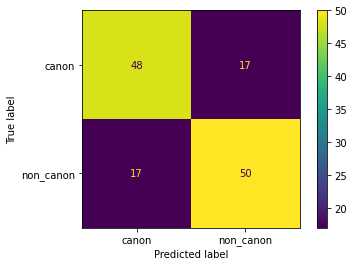

In [80]:
pipe, results, scores = canonizer(df_sizeopti_last)

In [96]:
df_unigram = df_sizeopti_last.iloc[:, 0:1400]

In [97]:
df_unigram['canon'] = df_sizeopti_last['canon']

Original dataset shape Counter({'non_canon': 288, 'canon': 240})
              precision    recall  f1-score  support
canon          0.707692  0.766667  0.736000    60.00
non_canon      0.791045  0.736111  0.762590    72.00
accuracy       0.750000  0.750000  0.750000     0.75
macro avg      0.749369  0.751389  0.749295   132.00
weighted avg   0.753157  0.750000  0.750504   132.00


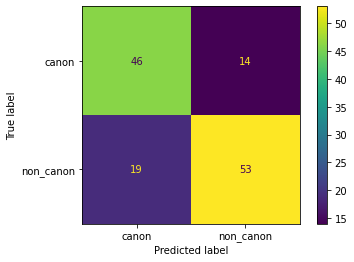

In [76]:
pipe, results, scores = canonizer(df_unigram)

In [59]:
results.to_csv(r'results_svm/results.csv', index=True)

Original dataset shape Counter({'non_canon': 294, 'canon': 234})
              precision    recall  f1-score     support
canon          0.757576  0.757576  0.757576   66.000000
non_canon      0.757576  0.757576  0.757576   66.000000
accuracy       0.757576  0.757576  0.757576    0.757576
macro avg      0.757576  0.757576  0.757576  132.000000
weighted avg   0.757576  0.757576  0.757576  132.000000


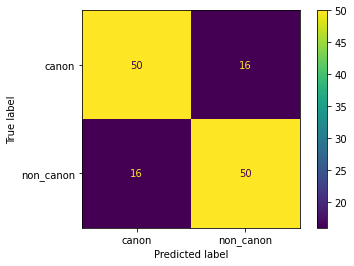

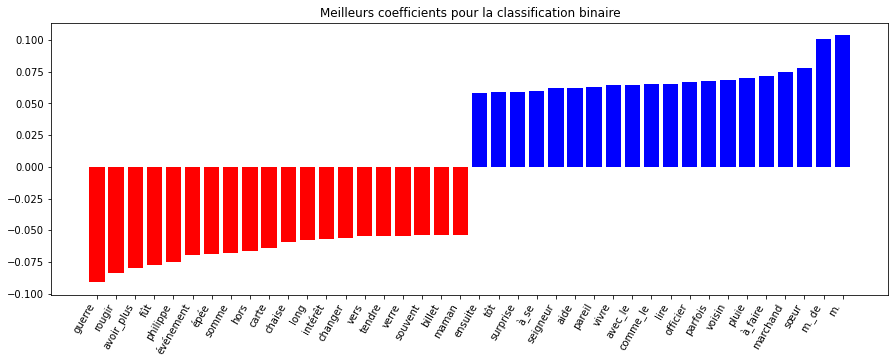

In [60]:
pipe, results, scores = canonizer(df_unigram, kernel='linear')

### RANDOM TEST

In [84]:
df_canon_random = df_unigram.iloc[:, 0:1000]

In [85]:
df_canon_random['canon'] = ['canon' if random.randint(0, 1) else 'non_canon' for i in range(len(df_canon_random))]

Original dataset shape Counter({'canon': 286, 'non_canon': 242})
              precision    recall  f1-score     support
canon          0.500000  0.691176  0.580247   68.000000
non_canon      0.447368  0.265625  0.333333   64.000000
accuracy       0.484848  0.484848  0.484848    0.484848
macro avg      0.473684  0.478401  0.456790  132.000000
weighted avg   0.474482  0.484848  0.460531  132.000000


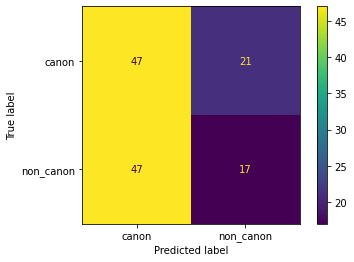

In [86]:
pipe, results, scores = canonizer(df_canon_random)

### Cross-Validation

In [158]:
pipe, results = canonizer(df_unigram, cross_validation=True)

              precision    recall  f1-score   support

       canon       0.79      0.75      0.77        60
   non_canon       0.80      0.83      0.82        72

    accuracy                           0.80       132
   macro avg       0.79      0.79      0.79       132
weighted avg       0.80      0.80      0.79       132

              precision    recall  f1-score   support

       canon       0.68      0.73      0.70        60
   non_canon       0.76      0.71      0.73        72

    accuracy                           0.72       132
   macro avg       0.72      0.72      0.72       132
weighted avg       0.72      0.72      0.72       132

              precision    recall  f1-score   support

       canon       0.70      0.78      0.74        60
   non_canon       0.80      0.72      0.76        72

    accuracy                           0.75       132
   macro avg       0.75      0.75      0.75       132
weighted avg       0.76      0.75      0.75       132

              preci

In [159]:
sum(results)/len(results)

0.7348484848484849

### Auteur metadata

In [160]:
def list_canon_opti(df_main, df_metadata_corpus):
    list_canon = []
    for elem in df_main.index:
        if elem in df_metadata_corpus.index:
            list_canon.append(df_metadata_corpus.loc[[elem]]['canon_auteur'][0])
            
    return list_canon

In [161]:
list_canon = list_canon_opti(df_main, df_metadata_corpus)

In [162]:
df_main['canon'] = list_canon

In [163]:
df_main.canon.value_counts()

non_canon    1787
canon        1173
Name: canon, dtype: int64

Original dataset shape Counter({'non_canon': 1411, 'canon': 957})
              precision    recall  f1-score    support
canon          0.840708  0.879630  0.859729  216.00000
non_canon      0.928962  0.904255  0.916442  376.00000
accuracy       0.895270  0.895270  0.895270    0.89527
macro avg      0.884835  0.891942  0.888085  592.00000
weighted avg   0.896761  0.895270  0.895749  592.00000


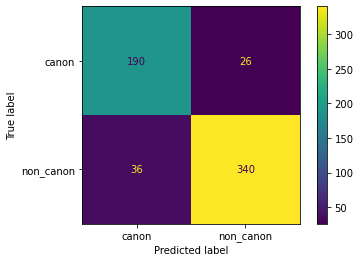

In [12]:
pipe, results, scores = canonizer(df_main)

In [13]:
df_main.canon.value_counts(normalize=True)

non_canon    0.603716
canon        0.396284
Name: canon, dtype: float64

In [164]:
def ratio_truncate_df(df, ratio_canon):
    
    df_res = shuffle(df)
    ratio_temp = round(df_res['canon'].value_counts(normalize=True)[1],2)
    index_noncanon = df_res[df_res['canon']  == 'non_canon'].index 
    i, j = 0, 20
        
    while ratio_temp < ratio_canon:
        df_res.drop(index_noncanon[i:j], inplace = True)
        i = j
        j+=20
        ratio_temp = round(df_res['canon'].value_counts(normalize=True)[1],2)

    return shuffle(df_res)

In [165]:
df_sizeopti_last = ratio_truncate_df(df_main, 0.45)

In [166]:
df_sizeopti_last.canon.value_counts()

non_canon    1447
canon        1173
Name: canon, dtype: int64

Original dataset shape Counter({'non_canon': 1157, 'canon': 939})
              precision    recall  f1-score     support
canon          0.856557  0.893162  0.874477  234.000000
non_canon      0.910714  0.879310  0.894737  290.000000
accuracy       0.885496  0.885496  0.885496    0.885496
macro avg      0.883636  0.886236  0.884607  524.000000
weighted avg   0.886530  0.885496  0.885690  524.000000


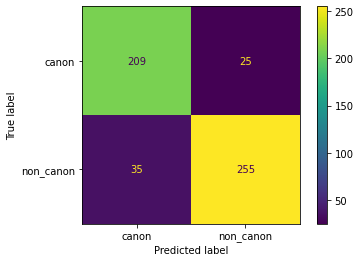

In [18]:
pipe, results, scores = canonizer(df_sizeopti_last)

In [19]:
results.to_csv(r'results_svm/results_authors.csv', index=True)

In [143]:
df_unigram = df_sizeopti_last.iloc[:, 0:1400]

In [144]:
df_unigram['canon'] = df_sizeopti_last['canon']

Original dataset shape Counter({'non-canon': 1148, 'canon': 916})
              precision    recall  f1-score     support
canon          0.882114  0.911765  0.896694  238.000000
non-canon      0.922222  0.895683  0.908759  278.000000
accuracy       0.903101  0.903101  0.903101    0.903101
macro avg      0.902168  0.903724  0.902727  516.000000
weighted avg   0.903723  0.903101  0.903194  516.000000


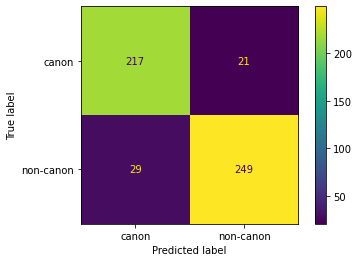

In [145]:
pipe, results, scores = canonizer(df_unigram)

In [149]:
pipe, results = canonizer(df_main, cross_validation=True)

              precision    recall  f1-score   support

       canon       0.88      0.89      0.89       231
   non-canon       0.93      0.92      0.93       361

    accuracy                           0.91       592
   macro avg       0.91      0.91      0.91       592
weighted avg       0.91      0.91      0.91       592

              precision    recall  f1-score   support

       canon       0.85      0.88      0.87       231
   non-canon       0.92      0.90      0.91       361

    accuracy                           0.89       592
   macro avg       0.89      0.89      0.89       592
weighted avg       0.89      0.89      0.89       592

              precision    recall  f1-score   support

       canon       0.88      0.87      0.88       231
   non-canon       0.92      0.93      0.92       361

    accuracy                           0.91       592
   macro avg       0.90      0.90      0.90       592
weighted avg       0.91      0.91      0.91       592

              preci

In [150]:
sum(results)/len(results)

0.9070945945945945

In [148]:
sum(results)/len(results)

0.8988372093023255

### Get dataset with one novel per author

In [170]:
def onetxtoneauthor(df):
    liste_vu, index_vu = [], []
    df_onetxtoneauthor = pd.DataFrame(columns = df.columns)
    
    for index, row in df.iterrows():
        auteur = index.split("_")[1].replace('-',' ')
        if auteur not in liste_vu:
            df_onetxtoneauthor.loc[len(df_onetxtoneauthor.index)] = row
            liste_vu.append(auteur)
            index_vu.append(index)
    df_onetxtoneauthor.index = index_vu
    return df_onetxtoneauthor

In [171]:
df_unigrams_ones = onetxtoneauthor(df_unigram)

In [172]:
df_unigrams_ones.canon.value_counts(normalize=True)

non_canon    0.612245
canon        0.387755
Name: canon, dtype: float64

In [173]:
df_unigrams_ones_opti = ratio_truncate_df(df_unigrams_ones, 0.45)

In [174]:
df_unigrams_ones_opti.canon.value_counts()

non_canon    140
canon        114
Name: canon, dtype: int64

Original dataset shape Counter({'non-canon': 154, 'canon': 129})
              precision    recall  f1-score   support
canon          0.794118  0.870968  0.830769  31.00000
non-canon      0.891892  0.825000  0.857143  40.00000
accuracy       0.845070  0.845070  0.845070   0.84507
macro avg      0.843005  0.847984  0.843956  71.00000
weighted avg   0.849202  0.845070  0.845628  71.00000


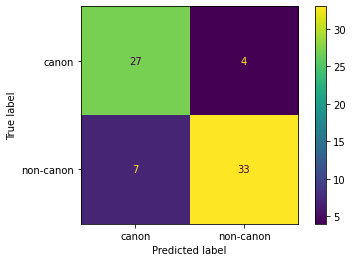

In [156]:
pipe, results, scores = canonizer(df_unigrams_ones_opti)

In [157]:
pipe, results = canonizer(df_unigrams_ones_opti, cross_validation=True)

              precision    recall  f1-score   support

       canon       0.78      0.78      0.78        32
   non-canon       0.82      0.82      0.82        39

    accuracy                           0.80        71
   macro avg       0.80      0.80      0.80        71
weighted avg       0.80      0.80      0.80        71

              precision    recall  f1-score   support

       canon       0.69      0.75      0.72        32
   non-canon       0.78      0.72      0.75        39

    accuracy                           0.73        71
   macro avg       0.73      0.73      0.73        71
weighted avg       0.74      0.73      0.73        71

              precision    recall  f1-score   support

       canon       0.72      0.91      0.81        32
   non-canon       0.90      0.72      0.80        39

    accuracy                           0.80        71
   macro avg       0.81      0.81      0.80        71
weighted avg       0.82      0.80      0.80        71

              preci

In [158]:
sum(results)/len(results)

0.7909054325955734

### Get dataset with max 5 novels per author 

In [159]:
def max_five_txt_by_author(df, n):
    liste_vu, index_vu = [], []
    df_onetxtoneauthor = pd.DataFrame(columns = df.columns)
    
    for index, row in df.iterrows():
        auteur = index.split("_")[1].replace('-',' ')
        
        if Counter(liste_vu)[auteur] <= 5:          
            df_onetxtoneauthor.loc[len(df_onetxtoneauthor.index)] = row
            liste_vu.append(auteur)
            index_vu.append(index)
    df_onetxtoneauthor.index = index_vu
    return df_onetxtoneauthor

In [160]:
df_unigrams_fives = max_five_txt_by_author(df_unigram, 5)

In [161]:
df_unigrams_fives.canon.value_counts(normalize=True)

non-canon    0.645102
canon        0.354898
Name: canon, dtype: float64

In [162]:
df_unigrams_fives_opti = ratio_truncate_df(df_unigrams_fives, 0.45)

Original dataset shape Counter({'non-canon': 565, 'canon': 461})
              precision    recall  f1-score     support
canon          0.826446  0.869565  0.847458  115.000000
non-canon      0.889706  0.852113  0.870504  142.000000
accuracy       0.859922  0.859922  0.859922    0.859922
macro avg      0.858076  0.860839  0.858981  257.000000
weighted avg   0.861399  0.859922  0.860191  257.000000


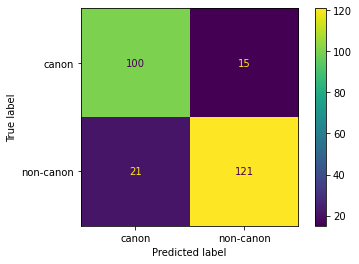

In [164]:
pipe, results, scores = canonizer(df_unigrams_fives_opti)

In [166]:
pipe, results = canonizer(df_unigrams_fives_opti, cross_validation=True)

              precision    recall  f1-score   support

       canon       0.80      0.90      0.85       115
   non-canon       0.91      0.82      0.86       142

    accuracy                           0.86       257
   macro avg       0.86      0.86      0.86       257
weighted avg       0.86      0.86      0.86       257

              precision    recall  f1-score   support

       canon       0.80      0.80      0.80       115
   non-canon       0.84      0.84      0.84       142

    accuracy                           0.82       257
   macro avg       0.82      0.82      0.82       257
weighted avg       0.82      0.82      0.82       257

              precision    recall  f1-score   support

       canon       0.75      0.85      0.80       116
   non-canon       0.86      0.77      0.81       141

    accuracy                           0.81       257
   macro avg       0.81      0.81      0.81       257
weighted avg       0.81      0.81      0.81       257

              preci

In [168]:
sum(results)/len(results)

0.8379043044747082